# Интерполяция временных рядов 

## Проблема недостающих значений 

Как только недостоверные данные идентифицированы и отброшены, самым важным шагом подготовки данных становится решение проблемы неполных данных.

Внесение значений взамен недостающих должно осуществляться с особой осторожностью, чтобы не нарушить закономерности, скрытые в существующих данных.

Явление недостающих данных может иметь различные причины: 

- если рассматривать данные из анкет, то на ряд вопросов анкеты респонденты могут отказаться отвечать (возраст, доход), посчитав их не относящимися к делу, или просто вопрос не заносится; 

- если мы получаем данные с датчика, то может иметь место неисправность (отсутствие измерения); датчик может оказаться вне досягаемости (например, если он использует беспроводную технологию передачи); значение было удалено вручную по каким-либо причинам и т. п. 

Данные проблемы можно решать по-разному: игнорироать атрибуты с высоким уровнем несоответствия, заполнять отсутствущие значения значениями средних, медианных или наивероятнейших значений, вносить их вручную, задействуя эксперта или дополнять их с помощью методов машинного обучения, таких как регрессия, деревья решений, наивный байесовский классификатор и др.


Многим из тех, кто сталкивается с научными и инженерными расчётами, часто приходится оперировать наборами значений, полученных опытным путём или методом случайной выборки. Как правило, на основании этих наборов требуется построить функцию, на которую могли бы с высокой точностью попадать другие получаемые значения. Такая задача называется **аппроксимацией**. **Интерполяцией** называют такую разновидность аппроксимации, при которой кривая построенной функции проходит точно через имеющиеся точки данных.



Рассмотрим несколько методов интерполяции данных:

In [2]:
#Для начала подгрузим необходимые модули и сами данные
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Данные ищите здесь:

https://disk.yandex.ru/d/9FAFpF_GoDCaVw

https://disk.yandex.ru/d/kks78oYeDgQDxg

In [3]:
# Set the working directory
import os
os.chdir("C:/Users/Анна/Desktop/ML занятия/HSE ML/HSE ML/DataSets")

In [4]:
# Read CSV files
data1 = pd.read_csv("DataSet3_1.csv", sep=",") #данные о температуре и потребляемой мощности электрической энергии (раноотстоящие узлы)
data2 = pd.read_csv("DataSet3_2.csv", sep=";") #данные о стоимости доллара и нефти (не равноотстоящие узлы)

In [5]:
# традиционно, сначала посмотрим на данные
# очевидно, данные представляют собой показания датчиков температуры и напряжения
data1.tail()
#OAT = Oudside Air Temperature

,Timestamp,OAT (F),Power (kW)
34935,12/30/2010 23:00,47,285.8
34936,12/30/2010 23:15,44,206.6
34937,12/30/2010 23:30,44,205.9
34938,12/30/2010 23:45,44,189.4
34939,12/31/2010 0:00,44,177.9


In [6]:
data2.head()

,Data,Dollar,Oil Brent
0,01.01.2020,"61,9057","66,39"
1,09.01.2020,"61,9057","65,34"
2,10.01.2020,"61,234","65,02"
3,11.01.2020,"61,2632","64,84"
4,14.01.2020,"60,9474","64,42"


In [7]:
# Convert timestamps to datetime objects
data1["Timestamp"] = pd.to_datetime(data1["Timestamp"], format="%m/%d/%Y %H:%M")
data2["Data"] = pd.to_datetime(data2["Data"], format="%d.%m.%Y")

## Интерполяция

#### Интерполяция для равноотстоящих точек

In [8]:
# Дату и время переводим в секунды начиная с 1/1/1970
#Для построения интерполяционной кривой выбираем неольшой отрезок [10:25]
#Наши данные
x = (data1["Timestamp"][10:25] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') # Convert to seconds since UNIX epoch
y = data1["Power (kW)"][10:25]

# Массив значений x1, которые мы хотим интерполировать
x1 = np.arange(x.values[0], x.values[-1], 1) #start, stop, step
x1 #то есть х1 - это посекундный отсчёт, The x-coordinates at which to evaluate the interpolated values

array([1262317500, 1262317501, 1262317502, ..., 1262330097, 1262330098,
       1262330099], dtype=int64)

### Линейная интерполяция

Формула линейной интерполяции имеет вид:

$f(x)=f(x_{i}) + \frac{f(x_{i+1})-f(x_{i})}{x_{i+1}-x_{i}} (x-x_{i})$, при $x_{i} \leq x \leq x_{i+1}$

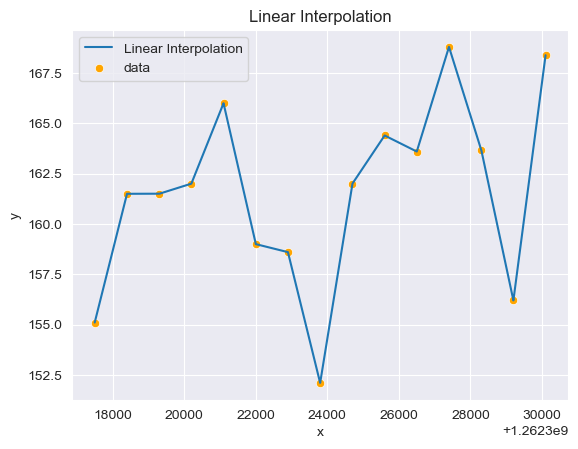

In [9]:
Linear = np.interp(x=x1, xp=x, fp=y)

sns.set_style("darkgrid")

# График линейной интерполяции
sns.lineplot(x=x1, y=Linear, label="Linear Interpolation")

# Диаграмма рассеяния
sns.scatterplot(x=x, y=y, color="orange", marker="o", label='data')

# Заголовок и подписи осей
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()

К сожалению, построенная таким образом аппроксимирующая кусочно-линейная функция не обладает гладкостью (первая производная этой функции терпит разрывы в узлах стыка полученных прямых). Поэтому рассмотрим другие методы интерполяции.

### Кубический сплайн

Попробуем использовать многочлены и строить интерполяционную функцию последовательно, звено за звеном. В результате получится так называемый полиномиальный многозвенник.

При таком подходе важно правильно выбрать степени привлекаемых многочленов, а для гладкости получаемой кривой необходимо тщательно подобрать коэффициенты многочленов (из условий гладкого сопряжения соседних звеньев). Результат применения такого подхода называют *сплайн-функциями* или *сплайнами*.

**Интерполяционным кубическим сплайном** называется функция $S(x)$ , обладающая следующими свойствами: 

- график этой функции проходит через каждую точку заданного набора точек $S(x_{i})=y_{i}, \forall i$;

- на каждом из отрезков $[x_{i}, x_{i+1}], i=1,..,n-1$ функция является многочленом третьей степени;

- на всем отрезке задания $[x_{0}, x_{n}]$ функция $S(x)$ имеет непрерывную вторую производную. 

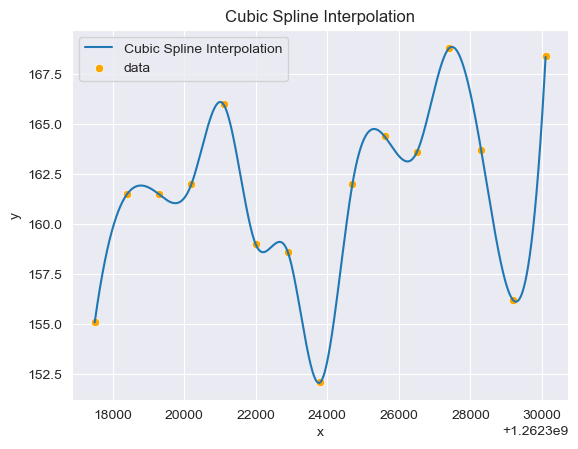

In [10]:
from scipy.interpolate import CubicSpline

# Наши данные x, y, и x1
f_cubic = CubicSpline(x, y)
S = f_cubic(x1)

# График кубической интерполяции
sns.lineplot(x=x1, y=S, label="Cubic Spline Interpolation")

# Диаграмма рассеяния
sns.scatterplot(x=x, y=y, color="orange", marker="o", label='data')

# Заголовок и подписи осей
plt.xlabel("x")
plt.ylabel("y")
plt.title("Cubic Spline Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()


#### Интерполяция для НЕ равноотстоящих точек

### Интерполяционная формула Лагранжа 

Пусть функция $f$ задана таблицей. Построим интерполяционный многочлен $L_{n}(x)$, степень которого не больше $n$. 

Будем искать $L_{n}(x)$ в виде:

$L_{n}(x)=l_{0}(x) +l_{1}(x)+...+l_{n}(x)$,

где $l_{i}(x)$ - многочлен степени $n$, задаваемый следующей функцией:

$l_{i}(x_{k})=\begin{cases} 
                y_{i}, i=k;
                \\
                 0, i \neq k 
                 \end{cases}$

После преобразований получим:

$L_{n} = \sum_{i=0, n} y_{i} \frac {(x - x_{0})* ... *(x - x_{n})} {(x_{i}-x_{0})*...*(x_{i}-x_{n})}$

Полученное выражение называют интерполяционным многочленом Лагранжа. 

In [11]:
x, y = np.array(x), np.array(y)
x

array([1262317500, 1262318400, 1262319300, 1262320200, 1262321100,
       1262322000, 1262322900, 1262323800, 1262324700, 1262325600,
       1262326500, 1262327400, 1262328300, 1262329200, 1262330100],
      dtype=int64)

In [12]:
def lagrange_interpolation(x_values, y_values, x):
    #TODO Дополнительное задание:
    #напишите код функции, вычисляющей значения коэффициентов полинома Лагранжа
    ''' 
    x_values: значения по x
    y-values: значения по y
    x: значения по оси x

    функция должна возвращать значение по y для построения графика
    '''


# Generate points for plotting the interpolated curve
y1 = [lagrange_interpolation(x, y, x_i) for x_i in x1]


#TODO: Постройте график по полученным значениям. Не забудьте нанести на график точки x, y!

In [ ]:
from scipy.interpolate import lagrange

#теперь используем встроенную функцию
lagrange_poly = lagrange(x, y) #Return a Lagrange interpolating polynomial
print(len(lagrange_poly))

y_interp = lagrange_poly(x1)

# График интерполяции Лагранжа
sns.lineplot(x=x1, y=y_interp, color="black", label="Lagrange Interpolation")

# Диаграмма рассеяния данных
sns.scatterplot(x=x, y=y, color="green", marker="o", label="Data")

# Заголовок и подписи осей
plt.xlabel("x")
plt.ylabel("y")
plt.title("Lagrange Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()


Вероятно, вы заметили проблемы...
Это действительно одна из "особенностей библиотеки Scipy.
Для того, чтобы построить правильный график, используем барицентрическую интерполяцию (barylag).

**Барицентрическая** интерполяция (Barycentric interpolation) - это метод интерполяции, который использует барицентрические веса для вычисления значений интерполяционной функции в точках между заданными узлами данных. Этот метод особенно полезен для интерполяции в случаях, когда узлы интерполяции имеют разные интервалы между ними или когда требуется высокая степень интерполяции.

Основная идея барицентрической интерполяции заключается в следующем:

1. Задаются узлы интерполяции $(x_{i}, y_{i})$, где $x_{i}$ - это значения независимой переменной, а $y_{i}$ - соответствующие им значения зависимой переменной.

2. Вычисляются барицентрические веса для каждой точки интерполяции. Эти веса используются для определения того, насколько каждый узел влияет на значение интерполяционной функции в данной точке.

3. Для интерполяции значения функции в новой точке x используются барицентрические веса и значения функции в узлах интерполяции.

Преимуществом барицентрической интерполяции является ее высокая эффективность и устойчивость к разреженным или неоднородным данным. Она также позволяет легко изменять степень интерполяции, добавляя или удаляя узлы. Этот метод широко используется в численном анализе и обработке данных для приближения функций и интерполяции данных.

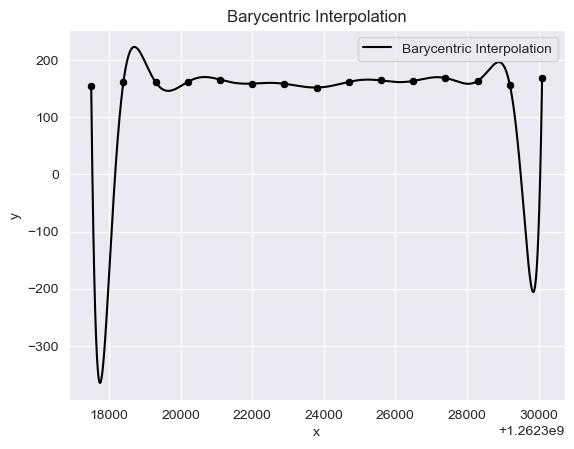

In [ ]:
from scipy.interpolate import barycentric_interpolate

# Barycentric (Barylag) interpolation
barylag_y = barycentric_interpolate(x, y, x1)

# График барицентрической интерполяции
sns.lineplot(x=x1, y=barylag_y, color="black", label="Barycentric Interpolation")

# Диаграмма рассеяния
sns.scatterplot(x=x, y=y, color="black", marker="o")

# Заголовок и подписи осей
plt.xlabel("x")
plt.ylabel("y")
plt.title("Barycentric Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()

### Формула Ньютона

Для функции с неравноотстоящими точками интерполяция может осуществляться по формуле Ньютона. В формуле Ньютона для неравноотстоящих узлов используются выражения, которые называют разделенными разностями.

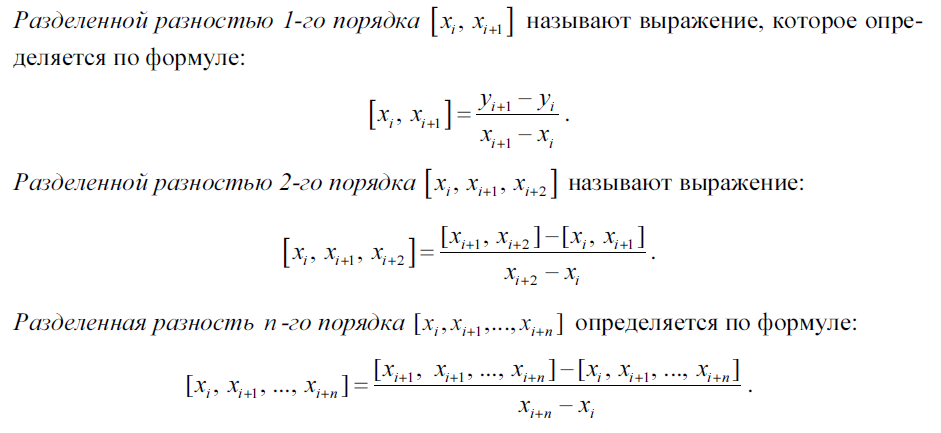

В приведенных формулах $x_{i}, y_{i}$ — значения аргумента и функции в узловых точках.

Запишем через разделенные разности интерполяционную формулу Ньютона для неравноотстоящих узловых точек:

$P(x)=y_{0}+[x_{0}, x_{1}](x-x_{0})+...+[x_{0},x_{1},...,x_{n}](x-x_{0})(x-x_{1})...(x-x_{n})$

In [ ]:
def _poly_newton_coefficient(x, y):
    """
    x: list or np array contanining x data points
    y: list or np array contanining y data points

    return a: коэффициент при очередном члене полинома Ньютона
    """
    #TODO: Реализуйте вычисление коэффициента

    return a

def newton_polynomial(x_data, y_data, x):
    """
    x_data: data points at x
    y_data: data points at y
    x: evaluation point(s)

    return p: значение по y в точке x
    """
    a = _poly_newton_coefficient(x_data, y_data)
    n = len(x_data) - 1  # Degree of polynomial
    p = a[n]

    for k in range(1, n + 1):
        #TODO: реализуте вычисление p
        pass

    return p

# Вычислите значения интерполяционного полинома для новых x1
y_interp =  [newton_polynomial(x, y, x_i) for x_i in x1]

# График интерполяции Лагранжа
sns.lineplot(x=x1, y=y_interp, color="black", label="Newton Interpolation")

# Диаграмма рассеяния данных
sns.scatterplot(x=x, y=y, color="green", marker="o", label="Data")

# Заголовок и подписи осей
plt.xlabel("x")
plt.ylabel("y")
plt.title("Newton Interpolation")

# Легенда
plt.legend()

# Отображение графика
plt.show()